# Base model

In [2]:
from utils import calculateVASPtemp
import matplotlib.pyplot as plt
import numpy as np
from ase.io import xyz,gen
from ase.atom import Atom
from ase.visualize import view

# x, y, z = 1.3, 3.2, 16.38 #location upon impact, to be treated as location of heat point source, MANUALLY set
x1, y1, z1 = 5.1, 1.4, 16.5
traj1 = [i for i in xyz.read_xyz("../100bomb.xyz", index = slice(0, -1, 1))]

x2, y2, z2 = 4.2, 3.3, 16.5
traj2 = [i for i in xyz.read_xyz("../350bomb.xyz", index = slice(0, -1, 1))]


In [6]:
# T0 = [100, 200, 300, 350, 400, 500]
T0 = [100, 300, 500, "geom.out"]
trajs = [
    [i for i in xyz.read_xyz("../{}.xyz".format(T), index = slice(0,-1, 1))]
    for T in T0 
]

In [7]:
impactLocs = [
    traj[0][-1].position for traj in trajs
]
for i in impactLocs:
    i[2] = 16.5
impactLocs

[array([ 5.08916472,  1.46998756, 16.5       ]),
 array([ 5.08916472,  1.46998756, 16.5       ]),
 array([ 5.08916472,  1.46998756, 16.5       ]),
 array([14.79257215,  7.27682439, 16.5       ])]

In [22]:
view(trajs[-1])

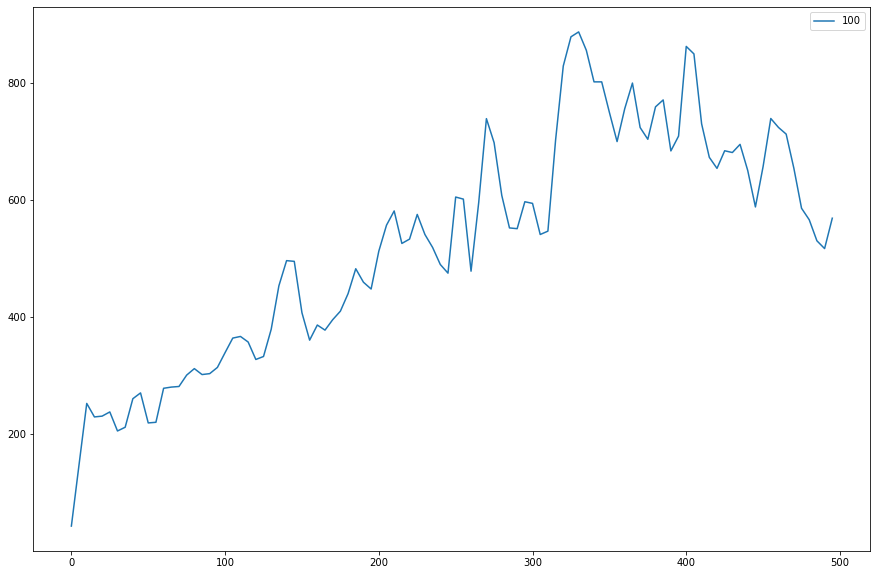

In [24]:
rCut = 5
plt.figure(figsize = (15,10))
for i, traj in enumerate([trajs[-1]]):
    temp = traj[0].copy()
    temp.append(Atom("He", position = impactLocs[i]))
#     mask = np.logical_and(temp.get_all_distances(mic = True)[-1] > rCut,
#                           np.array([a.position[2] > 13 for a in temp])
#                          )
    mask = np.logical_and(
        temp.get_all_distances(mic = True)[-1] < rCut ,
        [a.symbol in ["Si", "N", "H"] for a in temp]
    )
    mask = mask[:-1]
    natoms = sum(mask)
    mask[-1] = 0

    #get temps
    localTemps = []
    for frame in traj:
        frame.set_initial_charges(mask)
        v = frame.arrays['vel'][mask]
        T = calculateVASPtemp(v/1000, 0, frame[mask]) #Å/ps to Å/fs
        localTemps += [T]
    plt.plot(np.arange(0, len(localTemps)) * 5, localTemps, label = T0[i])
plt.legend()

# Fitting

Text(0, 0.5, 'Temperature (K)')

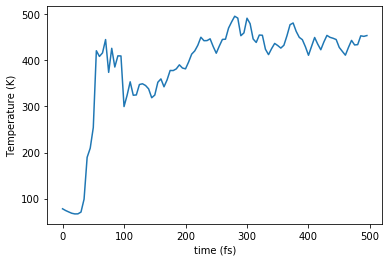

In [53]:
from scipy.signal import find_peaks
#identify cluster atoms
rCut = 0
traj = 1
# for rCut in [2, 3, 4, 6, 8, 10, 12, 14]:
if traj == 2:
    traj = traj2
    x, y, z = x2, y2, z2
if traj == 1:
    traj = traj1
    x, y, z = x1, y1, z1


for rCut in [rCut]:
    temp = traj[0].copy()
    temp.append(Atom("He", position = (x,y,z)))
#     mask = np.logical_and(temp.get_all_distances(mic = True)[-1] > rCut,
#                           np.array([a.position[2] > 13 for a in temp])
#                          )
    mask = temp.get_all_distances(mic = True)[-1] > rCut 
    mask = mask[:-1]
    natoms = sum(mask)
    mask[-1] = 0

    #get temps
    localTemps = []
    for frame in traj:
        frame.set_initial_charges(mask)
        v = frame.arrays['vel'][mask]
        T = calculateVASPtemp(v/1000, 0, frame[mask]) #Å/ps to Å/fs
        localTemps += [T]
    # plt.plot(localTemps)

    #find peak T 
    peaks = find_peaks(localTemps, prominence=3000)[0]
#     plt.scatter(peaks, [T for i,T in enumerate(localTemps) if i in peaks])
#     if len(peaks) > 1:
#         raise RuntimeError("more than one peak identified")

    #shift so peak T is 0
#     localTemps = localTemps[peaks[0]:]
    plt.plot(np.arange(0, len(localTemps)) * 5, localTemps, label = rCut)
# plt.yscale("log")
# plt.legend()
# plt.xlim(0, 100)
# plt.ylim(0, 600)
plt.xlabel("time (fs)")
plt.ylabel("Temperature (K)")
# plt.savefig("cooling_curve_dataonly.png", dpi = 400)

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from utils import amu2g

endTime = 400 * 1 #cutoff time, in fs, of interest
# natoms = 3
natoms #get this from mask length
# R_local = 3.0E-10 #meters assume ~2-3 atoms directly impacted at surface site
R_local = rCut * 1E-10 #use same cutoff as simulation analysis

#####################
## model 1 portion ##
#####################

# assume model of hollow sphere with R = 15 Å apart, shell thickness 2dR
# continum model assumes perfect and instantaenous collision with full transfer of KE
K = 3 # W/mK = J/mKs
dt = 2.98E-17 # seconds - corresponds to phonon time for 3 Å
A = 2 * np.pi * (R_local)**2 #meters squared
c = 673 #J/kg K, specific heat
m_local = np.sum([i.mass for i in traj[0][mask]]) * amu2g * 1E-3
T_bulk = 100 #K
# R_slab = 2700.0E-10 # meters, slab thickness, assume slab width >> thickness


Q = lambda dT: -K * A * (dT / R_local) * dt
dT = lambda Q: Q/(m_local * c)

fudge_factor = 1/2 #accounts for imperfect momentum transfer
T0 = (35/natoms)/(3/2 * kb_evK) * fudge_factor
temps = []
tempdiff = np.inf

while len(temps) * dt < endTime*1E-15:
    temps += [T0]
    _q = Q(T0 - T_bulk)
    T0 += dT(_q)
    if len(temps) > 1:
        tempdiff = temps[-2] - temps[-1] 
temps = np.array(temps)
plt.plot(np.arange(len(temps)) * dt * 1.0E15, temps, label = "model 1")

#####################
## model 2 portion ##
#####################

# assume model of hollow sphere with R = 15 Å apart, shell thickness 2dR
# continum model assumes perfect and instantaenous collision with full transfer of KE
K = 0.35 # W/mK = J/mKs
dt = 2.98E-17 # seconds - corresponds to phonon time for 3 Å
A = 2 * np.pi * (R_local)**2 #meters squared
c = 673 #J/kg K, specific heat
m_local = np.sum([i.mass for i in traj[0][mask]]) * amu2g * 1E-3
T_bulk = 100 #K
# R_slab = 2700.0E-10 # meters, slab thickness, assume slab width >> thickness


Q = lambda dT: -K * A * (dT / R_local) * dt
dT = lambda Q: Q/(m_local * c)

fudge_factor = 1/5 #accounts for imperfect momentum transfer
T0 = (35/natoms)/(3/2 * kb_evK) * fudge_factor
temps = []
tempdiff = np.inf

while len(temps) * dt < endTime*1E-15:
    temps += [T0]
    _q = Q(T0 - T_bulk)
    T0 += dT(_q)
    if len(temps) > 1:
        tempdiff = temps[-2] - temps[-1] 
temps = np.array(temps)
plt.plot(np.arange(len(temps)) * dt * 1.0E15 + 80, temps, label = "model 2")

###############
## plot data ##
###############

plt.plot(np.arange(0, len(localTemps), 1), localTemps, label = "data")
# plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim(0, endTime)
# plt.ylim(1000)
plt.ylabel("T (K)")
plt.xlabel("t (fs)")
# plt.savefig('cooling_curve_zoomed.png', dpi = 400)

NameError: name 'kb_evK' is not defined

In [ ]:
rCut

In [ ]:
7000 * np.exp(-1.0E12 * np.arange(len(temps)) * dt * 1.015)

In [ ]:
x = np.arange(100)
plt.yscale("log")
plt.plot(x, np.exp(-x))

In [ ]:
plt.plot(localTemps)
plt.xlim(150, 200)

In [ ]:
view(traj[-1])